# Symbolic Knowledge Injection
## Constraining a Neural Network with Symbolic Knowledge during Training

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

Some utility constants

In [2]:
map_class_to_label = {
    0: "High Card",
    1: "One Pair",
    2: "Two Pair",
    3: "Three of a Kind",
    4: "Straight",
    5: "Flush",
    6: "Full House",
    7: "Four of a Kind",
    8: "Straight Flush",
    9: "Royal Flush"
}

### Dataset

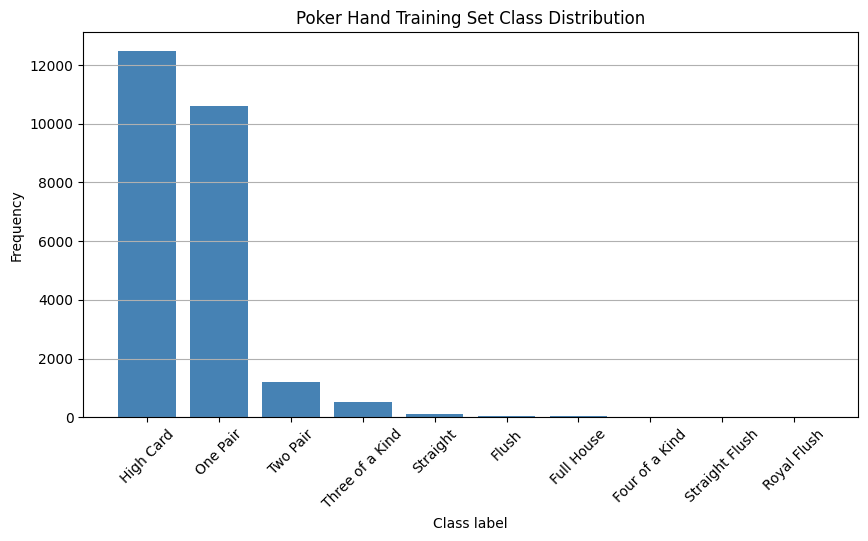

Training set statistics:
Class 0: 12493 samples
Class 1: 10599 samples
Class 2: 1206 samples
Class 3: 513 samples
Class 4: 93 samples
Class 5: 54 samples
Class 6: 36 samples
Class 7: 6 samples
Class 8: 5 samples
Class 9: 5 samples


In [3]:
train_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data", header=None)
test_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data", header=None)

cols = [f"card{i}_{attr}" for i in range(1, 6) for attr in ("suit", "rank")] + ["label"]
train_data.columns = cols
test_data.columns = cols

X_train = train_data.drop(columns=["label"]).values
y_train = train_data["label"].values
X_test = test_data.drop(columns=["label"]).values
y_test = test_data["label"].values

# Show class distribution
labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='steelblue')
plt.xlabel("Class label")
plt.ylabel("Frequency")
plt.title("Poker Hand Training Set Class Distribution")
plt.xticks(ticks=labels, labels=[map_class_to_label[label] for label in labels], rotation=45)
plt.grid(axis='y')
plt.show()

print("Training set statistics:")
for label, count in zip(labels, counts):
    print(f"Class {map_class_to_label[label]}: {count} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

### Neural Network Model

In [4]:
class PokerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)


### Knowledge Injection

In [5]:
def rule_two_pair(x_batch, pred_logits):
    ranks = x_batch[:, 1::2]  # shape (B, 5)
    rounded = torch.round((ranks - ranks.min(dim=1, keepdim=True)[0]) * 5)  # map to approx int
    penalties = []
    for i in range(ranks.size(0)):
        unique, counts = torch.unique(rounded[i], return_counts=True)
        pair_counts = (counts == 2).sum()
        is_two_pair = (pair_counts == 2)
        prob_class_2 = torch.softmax(pred_logits[i], dim=0)[2]
        penalties.append((is_two_pair.float() * (1 - prob_class_2))**2)
    return torch.stack(penalties).mean()

### Symbolic Loss Function

In [6]:
def symbolic_loss(x, pred_logits):
    loss = 0.0
    loss += rule_two_pair(x, pred_logits)
    # Additional rules can be added here
    return loss

### Training

In [7]:
def train_model(use_rules=False, lambda_reg=1.0):
    model = PokerNet()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            ce_loss = criterion(preds, yb)
            if use_rules:
                reg_loss = symbolic_loss(xb, preds)
                loss = ce_loss + lambda_reg * reg_loss
            else:
                loss = ce_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: loss = {total_loss/len(train_loader):.4f}")
    return model

### Evaluate

In [8]:
def evaluate(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            y_true.extend(yb.numpy())
            y_pred.extend(torch.argmax(preds, dim=1).numpy())
    report = classification_report(y_true, y_pred, labels=[9], target_names=["Two Pair"], zero_division=0)
    print(report)

### Comparison

In [9]:
print("--- Training without Symbolic Knowledge ---")
model_base = train_model(use_rules=False)
evaluate(model_base)

print("\n--- Training with Symbolic Knowledge ---")
model_symbolic = train_model(use_rules=True, lambda_reg=5.0)
evaluate(model_symbolic)

--- Training without Symbolic Knowledge ---
Epoch 1: loss = 1.1365
Epoch 2: loss = 0.9736
Epoch 3: loss = 0.9578
Epoch 4: loss = 0.9511
Epoch 5: loss = 0.9484
Epoch 6: loss = 0.9458
Epoch 7: loss = 0.9439
Epoch 8: loss = 0.9410
Epoch 9: loss = 0.9391
Epoch 10: loss = 0.9363
              precision    recall  f1-score   support

    Two Pair       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         3
   macro avg       0.00      0.00      0.00         3
weighted avg       0.00      0.00      0.00         3


--- Training with Symbolic Knowledge ---
Epoch 1: loss = 1.3312
Epoch 2: loss = 1.1767
Epoch 3: loss = 1.1568
Epoch 4: loss = 1.1473
Epoch 5: loss = 1.1443
Epoch 6: loss = 1.1412
Epoch 7: loss = 1.1396
Epoch 8: loss = 1.1365
Epoch 9: loss = 1.1338
Epoch 10: loss = 1.1324
              precision    recall  f1-score   support

    Two Pair       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         3
   macro avg   